In [1]:
import numpy as np
from scipy import constants
import tabulate
import pandas as pd
import matplotlib.pyplot as plt
# importing Vikrams functions
import sys
sys.path.insert(0,"/Users/ritika/SQRL_Rithi_python/XTalkRobustMS/tools")
#Github link to vikram's code is below
#https://github.com/SQRLab/XTalkRobustMS/blob/master/tools/IonChainTools.py
from IonChainTools import calcPositions,lengthScale

In [2]:
#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

In [3]:
def mode_calc_r(m,omega_r,omega_a):
    N = len(omega_r)
    A = np.zeros((N, N))
    l = lengthScale(omega_a)
    ueq = calcPositions(N)*l
    coloumb = ((e**2) / (4 * pi * eps0))
    masses = np.array([m for _ in range(N)])
    for i in range(N):
        A[i][i] = (masses[i] * omega_r[i]**2 - coloumb * sum(1 / (ueq[i] - ueq[m])**3 for m in range(0, i))
           - coloumb * sum(1 / (ueq[m] - ueq[i])**3 for m in range(i + 1, N))) * masses[i]
        for j in range(0, i):
            A[i][j] = (1/(ueq[i]-ueq[j])**3) * np.sqrt(masses[i])*np.sqrt(masses[j])*(coloumb)
        for j in range(i+1, N):
            A[i][j] = (1/ (ueq[j]-ueq[i])**3) *np.sqrt(masses[i])*np.sqrt(masses[j])*(coloumb)
    eigvals, eigvecs = np.linalg.eig(A) # this gives eigenvalues and eigenvectors
    freqs =( np.sqrt(1*eigvals))/(2*pi*m) #eigenvalue = spring constant k, so freq = sqrt(e-val)/(2*pi*m)
    
    
    scaledmodes = [(f, v) for f, v in zip(freqs, eigvecs.T)]
    scaledmodes = sorted(scaledmodes, key=lambda mode: mode[0],reverse=True)
    modes = []
    for f, scaledvec in scaledmodes:
        vec = np.array([scaledvec[i]/1 for i in range(len(eigvals))])
        vec = vec / np.sqrt(vec.dot(vec))
        modes.append((f, vec))
    return modes

In [4]:
#this is the edited version of Vikram's function to include real units and the ability to change omega
def mode_calc_a(m,omega_a):
    N = len(omega_a)
    A = np.zeros((N, N))
    l = lengthScale(omega_a)
    ueq = calcPositions(N)*l
    coloumb = ((e**2) / (4 * pi * eps0))
    masses = np.array([m for _ in range(N)])
    for i in range(N):
        A[i][i] = (masses[i] * omega_a[i]**2 + coloumb * sum(2 / (ueq[i] - ueq[m])**3 for m in range(0, i))
           + coloumb * sum(2 / (ueq[m] - ueq[i])**3 for m in range(i + 1, N))) * masses[i]
        for j in range(0, i):
            A[i][j] = (-2/(ueq[i]-ueq[j])**3) * np.sqrt(masses[i])*np.sqrt(masses[j])*(coloumb)
        for j in range(i+1, N):
            A[i][j] = (-2/ (ueq[j]-ueq[i])**3) *np.sqrt(masses[i])*np.sqrt(masses[j])*(coloumb)

    eigvals, eigvecs = np.linalg.eig(A) # this gives eigenvalues and eigenvectors
    freqs =( np.sqrt(1*eigvals))/(2*pi*m) #eigenvalue = spring constant k, so freq = sqrt(e-val)/(2*pi*m)
    print(freqs)
    
    
    scaledmodes = [(f, v) for f, v in zip(freqs, eigvecs.T)]
    scaledmodes = sorted(scaledmodes, key=lambda mode: mode[0],reverse=False)
    modes = []
    for f, scaledvec in scaledmodes:
        vec = np.array([scaledvec[i]/1 for i in range(len(eigvals))])
        vec = vec / np.sqrt(vec.dot(vec))
        modes.append((f, vec))
    return modes

In [5]:
N = 3
omega_rf_x = 1 * 2*pi * 1e6 * np.ones(N)
omega_a = 0.2*pi*1e6*2*np.ones(N)
base = mode_calc_r(m,omega_rf_x,omega_a)
print(base)

[(999999.9999999997, array([0.57735027, 0.57735027, 0.57735027])), (979795.897113271, array([ 7.07106781e-01, -5.60362463e-14, -7.07106781e-01])), (950789.1459203764, array([-0.40824829,  0.81649658, -0.40824829]))]


In [6]:
N = 3
omega_rf_x = 1 * 2*pi * 1e6 * np.ones(N)
omega_a = 0.2*pi*1e6*2*np.ones(N)
base = mode_calc_a(m,omega_a)
print(base)

[481663.78315169 346410.16151378 200000.        ]
[(199999.99999999994, array([0.57735027, 0.57735027, 0.57735027])), (346410.1615137754, array([ 7.07106781e-01, -6.08152198e-14, -7.07106781e-01])), (481663.7831516913, array([-0.40824829,  0.81649658, -0.40824829]))]


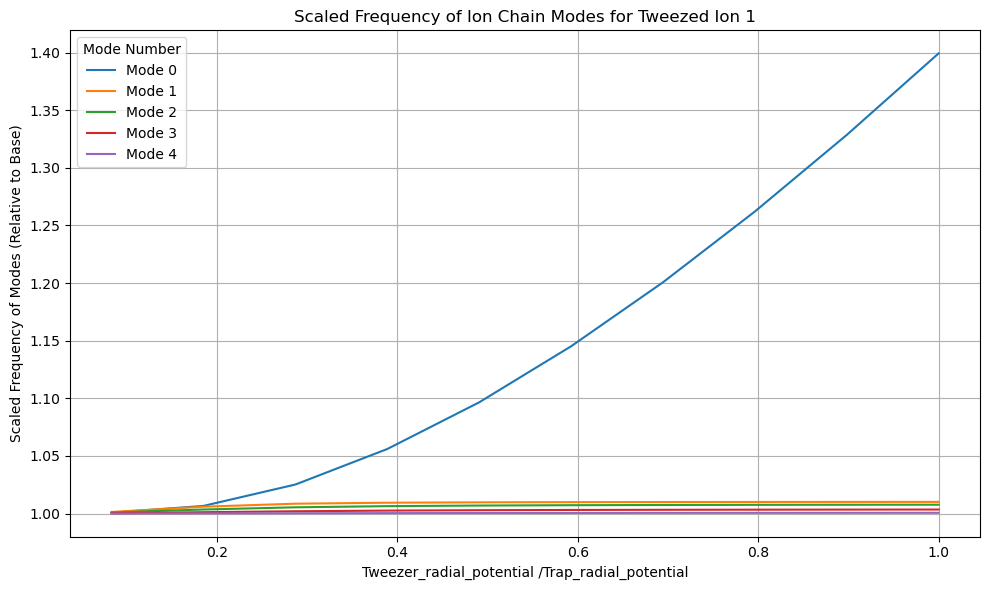

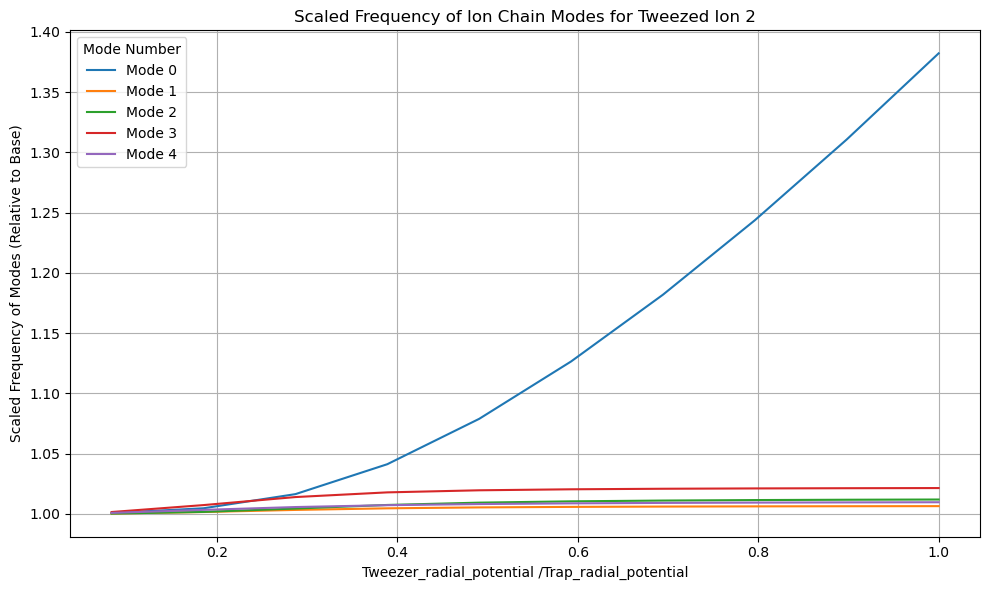

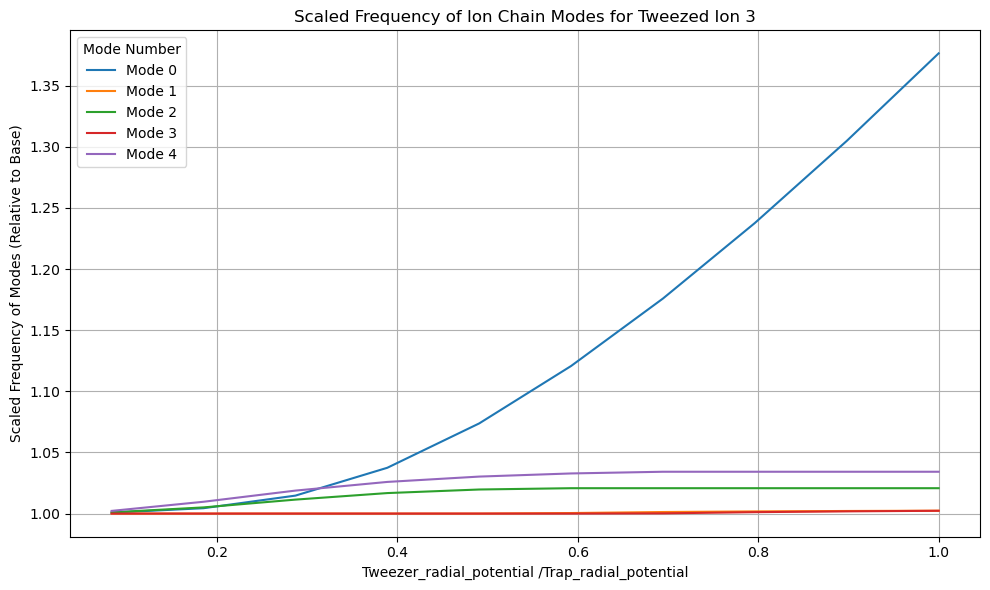

In [7]:
#this cell is the tweezer frequencies scaled by the base frequencies, using the same frequencies as Rajibul

N = 5
half_range = N - N//2
tweezed_ions = range(half_range)
omega_range_twee = np.linspace(0.1 * pi * 1e6, 1.2 * pi * 1e6, 10)# Range of omega for the tweezed ion
omega_rf_x = 1.2 * pi * 1e6 
#omega_a = omega_rf_x /3
omega_a = 0.2*pi*1e6
omega_rf_x = omega_rf_x * np.ones(N)#rf pseudopotential applied to all ions


for tweezed_ion in tweezed_ions:
    scaled_frequencies = []
    for i in omega_range_twee:
        omega_tw_x = np.zeros(N)
        omega_tw_x[tweezed_ion] = i  # Varying the tweezed ion's frequency
        omega_combined_x = np.sqrt(omega_tw_x**2 + omega_rf_x**2)
        modes_twee = mode_calc_r(m, omega_combined_x,omega_a)
        modes = mode_calc_r(m,omega_rf_x,omega_a)
        #print(modes_twee)
        #print(modes)
        freqs_twee = np.array([mode[0] for mode in modes_twee])  
        freqs = np.array([mode[0] for mode in modes])
        #print(freqs_twee)
        #print(freqs)
        scaled_freqs = freqs_twee/freqs
        #print(scaled_freqs)
        scaled_frequencies.append(scaled_freqs)
        #print(scaled_frequencies)
    scaled_frequencies = np.array(scaled_frequencies).T
    #print(scaled_frequencies)
    
     # Plotting each scaled mode's frequency for the current tweezed ion
    plt.figure(figsize=(10, 6))  # Create a new figure for each tweezed ion
    for mode_index, mode_freqs in enumerate(scaled_frequencies):
        plt.plot(omega_range_twee / (1.2*pi*1e6), mode_freqs, label=f"Mode {mode_index }")

    plt.xlabel("Tweezer_radial_potential /Trap_radial_potential")
    plt.ylabel("Scaled Frequency of Modes (Relative to Base)")
    plt.title(f"Scaled Frequency of Ion Chain Modes for Tweezed Ion {tweezed_ion + 1}")
    plt.legend(title="Mode Number")
    plt.grid(True)
    plt.tight_layout()
    plt.show()  # Show each plot